In [1]:
from cellpose.models import Cellpose
from hcrp import *
from skimage.io import imread
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from IPython import get_ipython
ipython = get_ipython()
if ipython.execution_count == 1:
    os.chdir('..') # because kernel initiates in scripts folder, only runs on first import
%matplotlib qt

In [10]:
# CHANGE TO PATH
folder = f"{get_path('dropbox.txt')}/Anqi/Intership/AI_segmentation/Dataset1_brk_dpp_pMad_Nuclei/Limb_Ext_Stg01"
filename = "Stg01_Emb03_T101.tif"
label_location = "data/Limb_Ext_Stg01_test"
channel_names = ["brk", "dpp", "pmad", "nuclear"]
channel_types = ["hcr", "hcr", "staining", "nuclear"]
results_path = f"data/{filename.split('.')[0]}_results"
# EDIT HCR PARAMETERS IF NEEDED
params = DEFAULT_HCR_PARAMS.copy()
params["dot_intensity_thresh"] = 1000
params["sigma_blur"] = 1
params["verbose"] = False
dpp_params = params.copy()
dpp_params["dot_intensity_thresh"] = None
dpp_params["sigma_blur"] = 1
hcr_params = [params, dpp_params, params, params]

In [16]:
# RUN THE CODE
# for some reason the matplotlib labelling doesn't work in notebooks. Use label.py to label.
midline, contour, background, z_midline = load_labels_safe(
    folder, label_location, filename
)
z = z_midline - 1
stack = imread(f"{folder}/{filename}")
masks, cell_data, hcr_data = process_layer(
    z,
    folder,
    filename,
    label_location,
    results_path=results_path,
    channel_names=channel_names,
    channel_types=channel_types,
    hcr_params=hcr_params,
)

Saved results to data/Stg01_Emb03_T101_results


In [18]:
# PLOT THE HCR RESULTS 
%matplotlib qt
fig, ax = plot_hcr(hcr_data[0], stack[z, :, :, 0])
ax[0].set(title=f"Layer {z}, {filename}: {channel_names[0]}")
plt.show()
%matplotlib qt
fig, ax = plot_hcr(hcr_data[1], stack[z, :, :, 1])
ax[0].set(title=f"Layer {z}, {filename}: {channel_names[1]}")
plt.show()


In [19]:
# PLOT ALLOCATION
%matplotlib qt
fig, ax = plot_hcr_cell_projection(hcr_data[0], cell_data, masks, stack[z, :, :, 0])
ax.set(title=f"Layer {z}, {filename}: {channel_names[0]}")
plt.show()

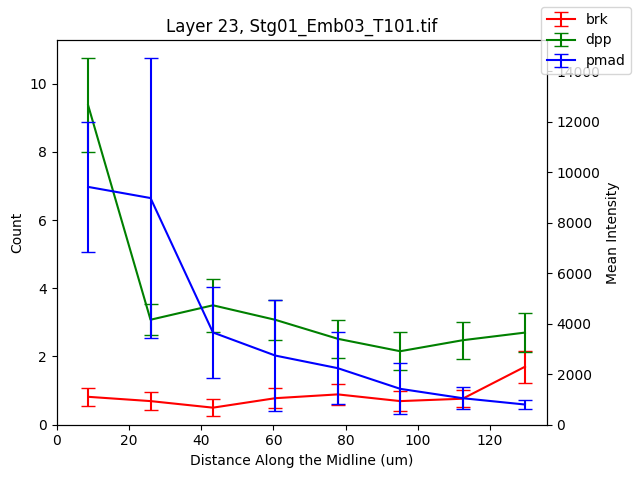

In [20]:
# PLOT GRADIENTS 
%matplotlib inline
fig, ax = plot_gradients(channel_names, channel_types, cell_data, pixel_to_mu=1/2.8906, err_type="std_err")
ax.set(title=f"Layer {z}, {filename}")  
plt.tight_layout()
plt.savefig(f"{results_path}/{filename.split('.')[0]}_gradients.pdf")

In [21]:
# RUN FOR MULTIPLE Z
z_range = range(z_midline-5, z_midline+5, 2)
cell_datas = []
for z in z_range:
    masks_z, cell_data_z, hcr_data_z = process_layer(
        z,
        folder,
        filename,
        label_location,
        results_path=results_path,
        channel_names=channel_names,
        channel_types=channel_types,
        hcr_params=[params, dpp_params, None, None],
    )
    cell_datas.append(cell_data_z)
cell_data_multi = pd.concat(cell_datas, ignore_index=True)

Saved results to data/Stg01_Emb03_T101_results
Saved results to data/Stg01_Emb03_T101_results
Saved results to data/Stg01_Emb03_T101_results
Saved results to data/Stg01_Emb03_T101_results
Saved results to data/Stg01_Emb03_T101_results


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Cell Property: endoderm'}>)

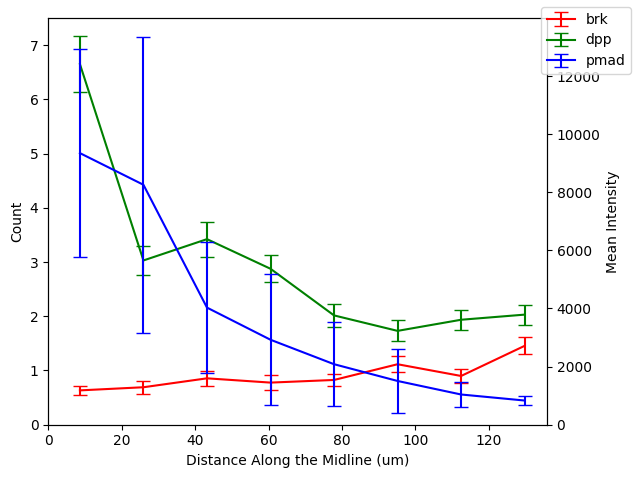

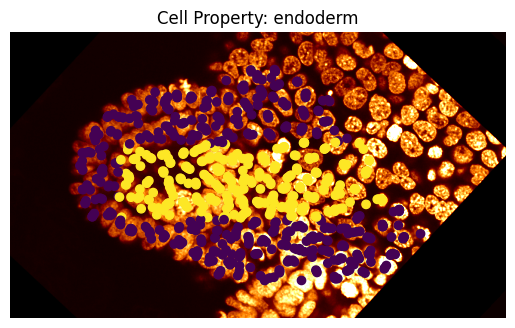

In [32]:
%matplotlib inline
fig, ax = plot_gradients(channel_names, channel_types, cell_data_multi, pixel_to_mu=1/2.8906, err_type="std_err")
# ax.set(title=f"Layer {z_range[0]}-{z_range[-1]}, {filename}")
# plt.tight_layout()
plot_cell_property(cell_data_multi, stack[z, :, :, 3], "endoderm")


In [26]:
%matplotlib qt
plot_hcr_cell_projection(hcr_data_z[1], cell_data_z, masks_z, stack[z, :, :, 3])

(<Figure size 640x480 with 1 Axes>, <Axes: >)

In [24]:
plt.imshow(stack[z, :, :, 3], cmap="gray")
plt.imshow(masks_z, cmap=get_random_cmap(masks_z.max()+1), alpha=0.3)

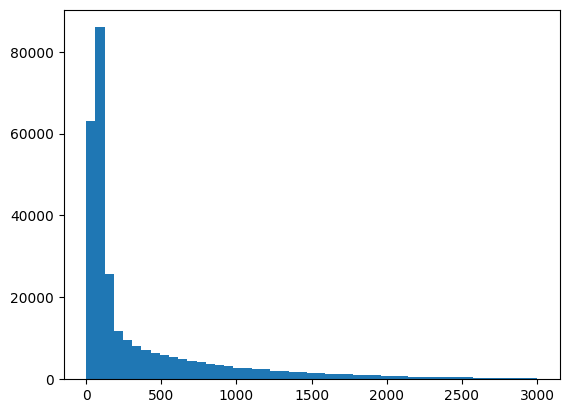

In [57]:
folder = f"{get_path('dropbox.txt')}/Anqi/Intership/AI_segmentation/Dataset1_brk_dpp_pMad_Nuclei/Limb_Ext_Stg01"
filename = "Stg01_Emb03_T102.tif"
stack = imread(f"{folder}/{filename}")
z = 10
hist = plt.hist(stack[z,:,:,0].flatten(), bins=np.linspace(0,3000))